In [194]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import scipy.stats as stats





DATA COLLECTION

1. Datos de Yahoo Finance

In [195]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Gold no existe. El ticker no baja ninguna información. Lo sustituyo por la volatilidad del mercado de oro que se descarga de los datos de la FED de St. Louis.

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importante participación del sector teconología. Hago lo mismo para las otras variables

In [196]:
start_date = '2000-01-01'
end_date = '2024-04-30'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [197]:
sp500.head()



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [198]:
sp500.shape

(6120, 7)

In [199]:
#Remueve las columans que no necesito
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remueve timezone porque tengo otras variables que no la tienen. para uniformar

In [200]:
#Guarda el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [201]:
#Hace lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [202]:
# Renombra la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
#print(oil.head())
oil.head()


,Close_oil
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


2. Datos de FRED (Banco de la Reserva Federal de St. Louis) -

Información económica diaria y que refleja expectativas del mercado. Como no existen variables fundamentales diarias relacionadas con el índice, 
incluyo variables diarias del mercado que reflejen el sentimiento de la evolución de la economía, lo cual afecta consecuentemente la evolución de las empresas y su valor.
Las variables macro y las fundamentales en general no suelen ser diarias (por ejemplo el desempleo, PIB, inflación, estados financieros)

In [203]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




3. Uno los dataframes de S&P 500, oil y variables alternativas

In [204]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='Date', length=6120, freq=None)


In [205]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  T10Y2Y  T10Y3M  \
Date                                                  ...                   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   -0.47   -0.56   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   -0.46   -0.56   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   -0.46   -0.58   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   -0.45   -0.54  

4. Cálculo de métricas de análisis técnico y cambios diarios (daily returns)

4.1. Cálculo de las variables para análisis técnico (variables calculadas a partir de los valores del índice). Ayudan a la toma de decisiones al dar información sobre el comportamiento del índice a través del tiempo.
Buscan determinar tendencias en el índice.

Medias moviles (dias hábiles)

In [206]:
#Calculo la media 
# Periodos para las medias móviles
moving_avg_periods = [5,10, 20,200]

# Calcular y asignar cada media móvil utilizando un bucle
for period in moving_avg_periods:
    AllVar_df[f'{period}d_moving_avg'] = AllVar_df['Close'].rolling(window=period).mean()

# Mostrar las primeras filas para verificar las nuevas columnas
AllVar_df.head()



,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,DEXCHUS,DEXCAUS,DEXMXUS,VIXCLS,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,8.2793,1.4877,9.2725,17.38,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,8.2799,1.4871,9.2440,17.04,NaN,31.629999,NaN,NaN,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,8.2799,1.4828,9.2320,16.53,NaN,32.049999,NaN,NaN,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,8.2799,1.4845,9.2130,16.54,NaN,32.869999,NaN,NaN,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,8.2799,1.4868,9.2325,16.89,NaN,32.720001,1508.931982,NaN,NaN,NaN


Media móvil ponderada (weighted moving average) últimos 10 días hábiles. Da más valor a los valores más recientes

In [207]:
#Calculo el promedio móvil ponderado de los ultimas 2 semanas

# Definimos los pesos decrecientes para los últimos 10 días hábiles.
weights = np.arange(1, 11)[::-1]  # Esto crea un array de numpy: [10, 9, ..., 2, 1]

# Calculamos el WMA para cada ventana de 10 días hábiles.
# Usamos apply para aplicar una función personalizada que calcula el WMA de manera vectorizada.
AllVar_df['10d_wma'] = AllVar_df['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Ahora, el DataFrame 'AllVar_df' contiene una nueva columna '10d_wma' con el WMA de 10 días.
# Muestra los primeros registros para verificar.
print(AllVar_df[['Close', '10d_wma']].head(20))


                  Close      10d_wma
Date                                
2000-08-23  1505.969971          NaN
2000-08-24  1508.310059          NaN
2000-08-25  1506.449951          NaN
2000-08-28  1514.089966          NaN
2000-08-29  1509.839966          NaN
2000-08-30  1502.589966          NaN
2000-08-31  1517.680054          NaN
2000-09-01  1520.770020          NaN
2000-09-05  1507.079956          NaN
2000-09-06  1492.250000  1509.020898
2000-09-07  1502.510010  1509.418539
2000-09-08  1494.500000  1509.139617
2000-09-11  1489.260010  1508.886353
2000-09-12  1481.989990  1506.660358
2000-09-13  1484.910034  1504.753820
2000-09-14  1480.869995  1503.770554
2000-09-15  1465.810059  1499.100546
2000-09-18  1444.510010  1492.482180
2000-09-19  1459.900024  1487.495099
2000-09-20  1451.339966  1484.460556


Momentum

In [208]:
# Calcular el momentum como el cambio día a día en la columna 'Close'. Es lo mismo que el daily change pero en absoluto no porcentual
AllVar_df['Momentum'] = AllVar_df['Close'].diff()

print(AllVar_df.head())  # Mostrar las primeras filas para verificar la nueva columna

                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  DEXMXUS  VIXCLS  \
Date                                                  ...                    
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   9.2725   17.38   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   9.2440   17.04   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   9.2320   16.53   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   9.2130   1

Stochastic %K (dónde se posiciona relativamente (%)  mi valor actual del rango de precios en un periodo de tiempo )

El Stochastic %K es una medida de la posición relativa del precio de cierre actual en relación con el rango alto-bajo durante un número específico de períodos pasados. La fórmula para calcular el Stochastic %K es la siguiente:

% K = [(C-LLn)/(HHn-LLn)]x 100 

donde:


C es el precio de cierre más reciente,

LLn es el precio más bajo de los prcios bajos (Low) en los últimos n períodos,
Hn  es el precio más alto de lso pecios altos (High) en los últimos n períodos,
n es el número de períodos utilizados para el cálculo.
El valor de n varía según el análisis, pero los valores comunes incluyen 14, 20 o cualquier otro valor dependiendo de la estrategia de trading

In [209]:
# Calcular el Stochastic %K para cada fila basado en los 20 días laborables previos


# Crea una función para encapsular el cálculo del Stochastic %K
def calculate_stochastic_k(row_index, df):
    if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        return None
    else:
        # Seleccionar los últimos 20 registros hasta el índice actual para las columnas 'High' y 'Low'
        high_period = df['High'][row_index-19:row_index+1]
        low_period = df['Low'][row_index-19:row_index+1]
        low_20 = low_period.min()
        high_20 = high_period.max()
        close_recent = df['Close'].iloc[row_index]
        
        # Calcular el Stochastic %K
        stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        return stochastic_k

# Aplica la función a cada fila
AllVar_df['Stochastic_%K'] = [calculate_stochastic_k(i, AllVar_df) for i in range(len(AllVar_df))]

# Muestra las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  VIXCLS  GVZCLS  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...   15.97   17.45   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...   15.37   17.32   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...   15.03   16.92   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...   14.67   

Stochastic %D (medias móviles del Stochastic %K)

El indicador Stochastic %D es una media móvil del indicador Stochastic %K. Usualmente se calcula como la media móvil simple de los últimos 3 valores de %K. 

In [210]:

# Calcular el Stochastic %D como la media móvil simple de 3 días de %K
AllVar_df['Stochastic_%D'] = AllVar_df['Stochastic_%K'].rolling(window=3).mean()


last_20_stochastic_D = AllVar_df['Stochastic_%D'][-20:]

print(last_20_stochastic_D)
AllVar_df.head(9)

Date
2024-04-03    76.922842
2024-04-04    57.726515
2024-04-05    55.575326
2024-04-08    53.829101
2024-04-09    64.992990
2024-04-10    54.961573
2024-04-11    53.283501
2024-04-12    35.318808
2024-04-15    25.095684
2024-04-16     7.141325
2024-04-17     5.118661
2024-04-18     4.821237
2024-04-19     4.569616
2024-04-22     8.741723
2024-04-23    20.099123
2024-04-24    31.278398
2024-04-25    35.328193
2024-04-26    38.522920
2024-04-29    43.766969
2024-04-30    42.643557
Name: Stochastic_%D, dtype: float64


,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,GVZCLS,Close_oil,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,31.629999,NaN,NaN,NaN,NaN,NaN,2.340088,NaN,NaN
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,32.049999,NaN,NaN,NaN,NaN,NaN,-1.860107,NaN,NaN
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,32.869999,NaN,NaN,NaN,NaN,NaN,7.640015,NaN,NaN
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,32.720001,1508.931982,NaN,NaN,NaN,NaN,-4.250000,NaN,NaN
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000,7.58,1.77,8.30,2.49,6.28,...,NaN,33.400002,1508.255981,NaN,NaN,NaN,NaN,-7.250000,NaN,NaN
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000,7.52,1.79,8.24,2.51,6.43,...,NaN,33.099998,1510.129980,NaN,NaN,NaN,NaN,15.090088,NaN,NaN
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000,7.51,1.83,8.22,2.54,6.48,...,NaN,33.380001,1512.993994,NaN,NaN,NaN,NaN,3.089966,NaN,NaN
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000,7.51,1.82,8.22,2.53,6.41,...,NaN,33.799999,1511.591992,NaN,NaN,NaN,NaN,-13.690063,NaN,NaN


El Índice de Fuerza Relativa (se puede entender como el nivel de "euforia" por comprar o vender el índice)

El Índice de Fuerza Relativa (RSI, por sus siglas en inglés) es un indicador de momento que mide la magnitud de los movimientos recientes de precios para evaluar condiciones de sobrecompra o sobreventa en el precio de un activo. Se calcula utilizando la fórmula:

RSI=100− 100/(1+RS)
 

donde 
RS es la relación media de días de cierre hacia arriba entre la media de días de cierre hacia abajo. Para calcularlo para los últimos 20 y 10 días, necesitamos seguir los siguientes pasos para cada ventana de tiempo:

Calcular los cambios diarios en el precio de cierre.
Separar estos cambios en ganancias (aumentos) y pérdidas (disminuciones).
Calcular el promedio de ganancias y el promedio de pérdidas sobre el período de interés (20 días y 10 días, respectivamente).
Calcular el RS, que es el promedio de ganancias dividido por el promedio de pérdidas.
Utilizar la fórmula del RSI para obtener el valor final.

In [211]:
# Separar las ganancias (positivas) de las pérdidas (negativas)
gain = AllVar_df['Momentum'].mask(AllVar_df['Momentum'] > 0, 0)
loss = -AllVar_df['Momentum'].mask(AllVar_df['Momentum'] < 0, 0)

# Calcular el RSI para los últimos 20 y 10 días
window_lengths = [20, 10]

for length in window_lengths:
    # Calcular el promedio de ganancias y pérdidas
    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()
    
    # Calcular RS
    rs = avg_gain / avg_loss
    
    # Calcular RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Adjuntar al DataFrame
    AllVar_df[f'RSI_{length}'] = rsi

# Mostrar las últimas 20 filas para verificar las nuevas columnas
print(AllVar_df.tail(20))



                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-03  5194.370117  5228.750000  5194.370117  5211.490234  3703250000   
2024-04-04  5244.049805  5256.589844  5146.060059  5147.209961  4075680000   
2024-04-05  5158.950195  5222.180176  5157.209961  5204.339844  3386780000   
2024-04-08  5211.370117  5219.569824  5197.350098  5202.390137  3278180000   
2024-04-09  5217.029785  5224.810059  5160.779785  5209.910156  3400680000   
2024-04-10  5167.879883  5178.430176  5138.700195  5160.640137  3845930000   
2024-04-11  5172.950195  5211.779785  5138.770020  5199.060059  3509380000   
2024-04-12  5171.509766  5175.029785  5107.939941  5123.410156  3963220000   
2024-04-15  5149.669922  5168.430176  5052.470215  5061.819824  3950210000   
2024-04-16  5064.589844  5079.839844  5039.830078  5051.410156  4006200000   
2024-04-17  5068.970215  5077.959961  5007.250000  5022.209961  

Indicador Larry Williams %R (el contrario del Stochastic %K, qué tan cerca estoy de mi precio máximo)

El indicador Larry Williams %R es una medida de momentum que se utiliza para identificar niveles de sobrecompra y sobreventa en un mercado. Se calcula como un porcentaje que refleja la posición del precio de cierre relativo a su rango más alto y más bajo durante un número específico de períodos pasados. La fórmula del Larry Williams %R es:

%R= [(Hn-C)/(Hn-Ln)]x100

donde:

C es el precio de cierre actual,
Hn  es el precio más alto en los últimos n períodos,
Ln es el precio más bajo en los últimos 
n períodos,
n es el número de períodos utilizados para el cálculo.
Generalmente, se utiliza un período de 14 días para el cálculo de este indicador, pero se puede ajustar según las necesidades del análisis.

In [212]:
# Asumiendo que sp500 es tu DataFrame y tiene columnas 'High', 'Low', y 'Close' con los precios más altos, más bajos y de cierre

# Configurar el número de períodos para el cálculo de Williams %R
n = 10

# Calcular el precio más alto y el más bajo de los últimos n días
high_n = AllVar_df['High'].rolling(window=n).max()
low_n = AllVar_df['Low'].rolling(window=n).min()

# Calcular el Williams %R
AllVar_df['Williams_%R'] = ((high_n - AllVar_df['Close']) / (high_n - low_n)) * -100

# Mostrar las últimas filas para verificar la nueva columna
print(AllVar_df.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  10d_moving_avg  \
Date                                                  ...                   
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...     5058.904004   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...     5043.839990   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...     5041.494971   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...     5046.9

Moving Average Convergence/Divergence Oscillator (toma en cuenta las tendencias y el momentum al comparar las medias móviles)

El MACD convierte dos indicadores de seguimiento de tendencias, las medias móviles, en un oscilador de momentum al restar la media móvil más larga de la más corta. Como resultado, el MACD ofrece lo mejor de ambos mundos: seguimiento de tendencias y momentum. El MACD fluctúa por encima y por debajo de la línea cero a medida que las medias móviles convergen, se cruzan y divergen. Los traders pueden buscar cruces de la línea de señal, cruces de la línea central y divergencias para generar señales. Debido a que el MACD no tiene límites, no es particularmente útil para identificar niveles de sobrecompra y sobreventa.

In [213]:
#https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


# Calcular las EMAs de 12 y 26 períodos para la columna 'Close'
ema12 = AllVar_df['Close'].ewm(span=12, adjust=False).mean()
ema26 = AllVar_df['Close'].ewm(span=26, adjust=False).mean()

# Calcular el MACD restando la EMA de 26 períodos de la EMA de 12 períodos
AllVar_df['MACD'] = ema12 - ema26

# Calcular la línea de señal como la EMA de 9 períodos del MACD
AllVar_df['Signal_Line'] = AllVar_df['MACD'].ewm(span=9, adjust=False).mean()

# Mostrar las últimas filas para verificar las nuevas columnas
print(AllVar_df.tail())
AllVar_df.head()


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   
2024-04-29  5114.129883  5123.490234  5088.649902  5116.169922  3447450000   
2024-04-30  5103.779785  5110.830078  5035.310059  5035.689941  4082470000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  200d_moving_avg  \
Date                                                  ...                    
2024-04-24  5.41    0.76  6.13    1.48          3.19  ...      4683.744802   
2024-04-25  5.45    0.75  6.17    1.47          3.24  ...      4686.790603   
2024-04-26  5.39    0.72  6.12    1.45          3.16  ...      4689.929602   
2024-04-29  5.35    0.72  6.08    1.45          3.12  ...      

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,RSI_10,Williams_%R,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,NaN,NaN,2.340088,NaN,NaN,0.000000,0.000000,NaN,0.186674,0.037335
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,NaN,NaN,-1.860107,NaN,NaN,44.286213,44.286213,NaN,0.182416,0.066351
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,NaN,NaN,7.640015,NaN,NaN,15.710088,15.710088,NaN,0.786461,0.210373
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,NaN,NaN,-4.250000,NaN,NaN,37.974069,37.974069,NaN,0.911722,0.350643


4.2. Cambios diarios para variables alternativas

Trabajo con daily changes y no números absolutos porque ARIMA y modelos en general trabajan mejor con series estacionarias. Para observaciones diarias, los cambios diarios son una forma común de estacionarizar la serie temporal.


La capacidad de los modelos ARIMA, Logit, Random Forest y LSTM para manejar variables no estacionarias varía considerablemente según la naturaleza del modelo y su propósito. A continuación el detalle de cómo cada uno puede gestionar o verse afectado por la no estacionariedad de las variables:

1. ARIMA (AutoRegressive Integrated Moving Average)
Sensibilidad a la Estacionariedad: ARIMA requiere que las series temporales de la variable dependiente sean estacionarias para realizar predicciones efectivas. La estacionariedad significa que las propiedades estadísticas como la media y la varianza de la serie deben ser constantes a lo largo del tiempo.
Diferenciación: Para tratar series temporales no estacionarias, ARIMA incluye un componente de diferenciación (el "Integrated" en ARIMA), que puede transformar una serie temporal no estacionaria en estacionaria. Este proceso es fundamental antes de ajustar un modelo ARIMA.
2. Logit (Regresión Logística)
Tolerancia a la No Estacionariedad: La regresión logística no tiene requisitos específicos sobre la estacionariedad de las variables predictoras. Se centra en modelar la probabilidad de una variable de resultado binaria basada en uno o más predictores. Sin embargo, la no estacionariedad en los predictores puede afectar la generalización y la interpretación del modelo, ya que los predictores pueden cambiar sus comportamientos a lo largo del tiempo.
3. Random Forest
Robustez frente a la No Estacionariedad: Random Forest es un modelo de aprendizaje automático que es bastante robusto frente a muchas de las suposiciones estadísticas requeridas por modelos más tradicionales. Puede manejar bien predictores no estacionarios, ya que no asume nada sobre la distribución de los predictores. No obstante, la variabilidad en la importancia de las características y la predictibilidad puede ser más difícil de interpretar si las características son no estacionarias.
4. LSTM (Long Short-Term Memory)
Diseñado para Datos Secuenciales: Las redes LSTM están diseñadas para trabajar con secuencias de datos y son capaces de aprender dependencias a largo plazo en series temporales. Aunque las LSTMs pueden manejar cierto grado de no estacionariedad debido a su capacidad para modelar dinámicas temporales complejas, el rendimiento del modelo puede beneficiarse de series que exhiben estacionariedad. En la práctica, a menudo se preprocesan los datos para estabilizar la media y la varianza, y mejorar así el aprendizaje y la predicción.
Resumen
ARIMA requiere explícitamente que las series sean estacionarias y utiliza técnicas de diferenciación para lograr esto.
Logit no necesita que las variables sean estacionarias, pero la no estacionariedad puede complicar la interpretación.
Random Forest y LSTM son más flexibles y robustos frente a la no estacionariedad, aunque el preprocesamiento puede mejorar la interpretación y el rendimiento del modelo.
En todos los casos, aunque algunos modelos pueden manejar la no estacionariedad hasta cierto punto, el preprocesamiento de los datos para abordar la no estacionariedad puede facilitar la modelización, mejorar la interpretación de los resultados y aumentar la precisión de las predicciones.

In [214]:
# Calcular los retornos diarios 
retornos_diarios = AllVar_df[['Close']].pct_change()

# Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
AllVar_df['Daily Returns'] = retornos_diarios




In [215]:
columns_to_change = [
    'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 
    'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 
    'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS'
]
for column in columns_to_change:
    new_column_name = f'{column}_daily_change'
    AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100

print(AllVar_df.head())


                   Open         High          Low        Close     Volume  \
Date                                                                        
2000-08-23  1498.130005  1507.199951  1489.520020  1505.969971  871000000   
2000-08-24  1505.969971  1511.160034  1501.250000  1508.310059  837100000   
2000-08-25  1508.310059  1513.469971  1505.089966  1506.449951  685600000   
2000-08-28  1506.449951  1523.949951  1506.449951  1514.089966  733600000   
2000-08-29  1514.089966  1514.810059  1505.459961  1509.839966  795600000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2000-08-23  7.55    1.82  8.26    2.53          6.43  ...   
2000-08-24  7.51    1.78  8.22    2.49          6.44  ...   
2000-08-25  7.52    1.79  8.23    2.50          6.42  ...   
2000-08-28  7.56    1.78  8.27    2.49          6.36  ...   
2000-08-29  7.58    1.77  8.30    2.49          6.30  ...   

            BAMLHE00EHYIOAS_dail

C:\Users\lgarn\AppData\Local\Temp\ipykernel_19132\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_19132\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  AllVar_df[new_column_name] = AllVar_df[column].pct_change() * 100
C:\Users\lgarn\AppData\Local\Temp\ipykernel_19132\2385237343.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to callin

In [216]:
# Calcula los cambios diarios en el precio del oil.
AllVar_df['oil_daily_changes'] = AllVar_df['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


In [217]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-23,1498.130005,1507.199951,1489.520020,1505.969971,871000000,7.55,1.82,8.26,2.53,6.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-24,1505.969971,1511.160034,1501.250000,1508.310059,837100000,7.51,1.78,8.22,2.49,6.44,...,-2.127660,0.000000,NaN,0.680272,0.007247,-0.040331,-0.307360,-1.956272,NaN,-1.310453
2000-08-25,1508.310059,1513.469971,1505.089966,1506.449951,685600000,7.52,1.79,8.23,2.50,6.42,...,0.000000,3.571429,NaN,-0.044307,0.000000,-0.289153,-0.129814,-2.992958,NaN,1.327854
2000-08-28,1506.449951,1523.949951,1506.449951,1514.089966,733600000,7.56,1.78,8.27,2.49,6.36,...,-2.173913,-6.896552,NaN,-0.243794,0.000000,0.114648,-0.205806,0.060496,NaN,2.558501
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,7.58,1.77,8.30,2.49,6.30,...,0.000000,-7.407407,NaN,-0.399911,0.000000,0.154934,0.211657,2.116082,NaN,-0.456336


4.3. Limpieza de valores nulos e infinitos

In [218]:
# Contar los valores nulos en cada columna
null_counts_All= AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_All)

# Reemplazar los valores infinitos por NaN
AllVar_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas con valores nulos o NaN
AllVar_df = AllVar_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean =AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
AllVar_df.to_csv("AllVar_df_clean.csv")


Conteo de valores nulos por columna antes de limpiar:
 Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
DAAA                              39
AAA10Y                            44
DBAA                              39
BAA10Y                            44
BAMLH0A0HYM2                       2
BAMLH0A2HYB                        2
BAMLH0A3HYC                        2
BAMLHE00EHYIOAS                    2
T10Y2Y                            42
T10Y3M                            42
T5YIE                            622
DEXUSEU                           53
DEXCHUS                           53
DEXCAUS                           53
DEXMXUS                           53
VIXCLS                             0
GVZCLS                          1940
Close_oil                          0
5d_moving_avg                      4
10d_moving_avg                     9
20d_moving_avg      

IMPORTANTE: cuando se unen todas las variables en AllVar_df, se cambia año de inicio al 2008 porque es cuando hay datos para todas.

In [219]:
AllVar_df.head()

,Open,High,Low,Close,Volume,DAAA,AAA10Y,DBAA,BAA10Y,BAMLH0A0HYM2,...,T10Y2Y_daily_change,T10Y3M_daily_change,T5YIE_daily_change,DEXUSEU_daily_change,DEXCHUS_daily_change,DEXCAUS_daily_change,DEXMXUS_daily_change,VIXCLS_daily_change,GVZCLS_daily_change,oil_daily_changes
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-04,1376.260010,1388.180054,1371.739990,1377.199951,4338640000,5.64,1.66,7.02,3.04,6.79,...,2.721088,3.381643,-1.694915,-0.006471,0.421107,0.935230,0.291545,2.766798,-0.873744,-1.616921
2008-06-05,1377.479980,1404.050049,1377.479980,1404.050049,4350790000,5.69,1.63,7.07,3.01,6.63,...,1.986755,3.271028,2.155172,0.692422,-0.248445,0.492854,-0.077519,-10.432692,0.396651,4.488960
2008-06-06,1400.060059,1400.060059,1359.900024,1360.680054,4771660000,5.61,1.67,6.98,3.04,6.68,...,0.000000,-5.429864,3.375527,1.098972,-0.331126,-0.078470,0.543057,26.462695,3.599649,8.412233
2008-06-09,1360.829956,1370.630005,1350.619995,1361.760010,4404570000,5.58,1.56,6.96,2.94,6.58,...,-16.233766,1.913876,1.224490,-0.082639,0.000000,0.353392,-0.038580,-1.867572,3.686441,-3.024388
2008-06-10,1358.979980,1366.839966,1351.560059,1358.439941,4635070000,5.66,1.55,7.05,2.94,6.49,...,-6.976744,-1.877934,0.000000,-1.558722,0.026000,0.176074,0.231571,0.259516,3.759706,-2.262753


In [220]:
#Determino el periodo de datos disponibles para todas las variables. Luego se utilizarán para entrenar y probar el modelo una vez que se seleccione el día de incio del análisis
start_date_All = AllVar_df.index.min()
end_date_All = AllVar_df.index.max()
print(f"Los datos comienzan el: {start_date_All}")
print(f"Los datos terminan el: {end_date_All}")

Los datos comienzan el: 2008-06-04 00:00:00
Los datos terminan el: 2024-04-30 00:00:00


In [221]:
#Defino el día de inicio del análisis
fecha_inicio = '2014-04-30'

# Se confima que el índice es de tipo DateTimeIndex (se necesita para algunos modelos)
AllVar_df.index = pd.to_datetime(AllVar_df.index)


# Filtrar el DataFrame para que todas las columnas comiencen desde la fecha de inicio
AllVar_df = AllVar_df.loc[fecha_inicio:]


ANÁLISIS DE LA SERIE HISTORICA

In [222]:
datos_sp500 = AllVar_df[['Close']]

In [223]:
# Calcular los retornos diarios 
retornos_diarios = datos_sp500[['Close']].pct_change()

# Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
datos_sp500['Daily Returns'] = retornos_diarios




C:\Users\lgarn\AppData\Local\Temp\ipykernel_19132\2325259474.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_sp500['Daily Returns'] = retornos_diarios


ESTADISTICA DESCRIPTIVA

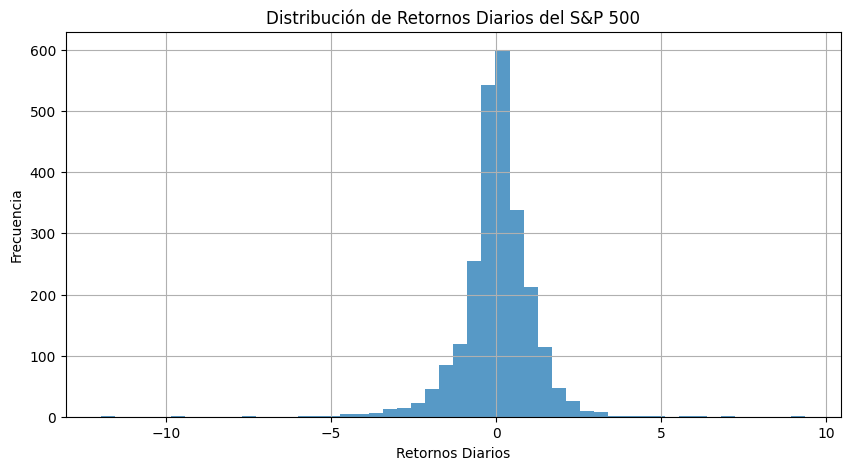

In [224]:
# Crear el histograma de los retornos diarios
plt.figure(figsize=[10,5])
plt.hist(datos_sp500['Daily Returns'].dropna(), bins=50, alpha=0.75)
plt.title('Distribución de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

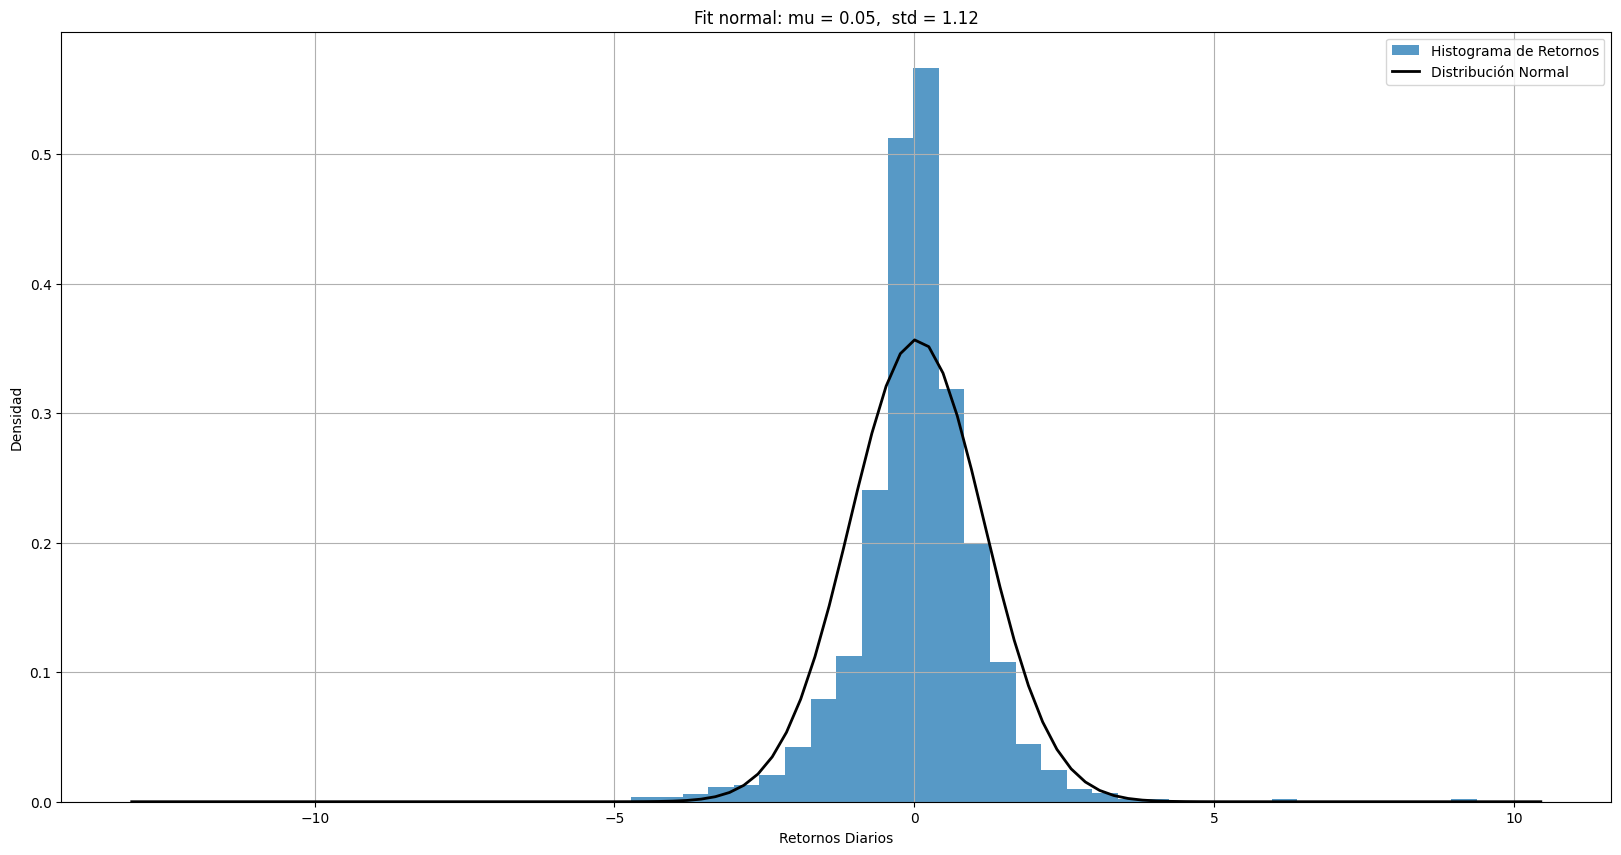

In [225]:
# Elimina cualquier NaN para asegurar que la visualización y los cálculos se realicen correctamente
daily_returns = datos_sp500['Daily Returns'].dropna()

# Crear el histograma de los retornos diarios
plt.figure(figsize=[20, 10])
# Histograma de los retornos
count, bins, ignored = plt.hist(daily_returns, bins=50, alpha=0.75, density=True, label='Histograma de Retornos')

# Ajustar y superponer una distribución normal sobre el histograma
mu, std = stats.norm.fit(daily_returns)  # Calcular la media y la desviación estándar de los datos
xmin, xmax = plt.xlim()  # Obtener los límites del eje x del histograma para el plot de la normal
x = np.linspace(xmin, xmax, 100)  # Generar puntos x entre los límites de x, con igual espacio
p = stats.norm.pdf(x, mu, std)  # Calcular la densidad de la distribución normal en estos puntos

# Dibujar la curva de la distribución normal
plt.plot(x, p, 'k', linewidth=2, label='Distribución Normal')

title = "Fit normal: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Retornos Diarios')
plt.ylabel('Densidad')
plt.grid(True)
plt.legend()  # Añadir una leyenda para identificar el histograma y la curva normal

# Mostrar el gráfico
plt.show()


1. Distribución de los Retornos

Centralidad: La media de los retornos diarios, indicada por mu, es aproximadamente 0.05. Esto sugiere que los retornos promedio son levemente positivos.

Volatilidad: La desviación estándar de 1.12 sugiere una cierta volatilidad en los retornos diarios, lo que es común en los mercados financieros.

2. Normalidad de los Datos
Comparación con la Normalidad: La curva negra representa la distribución normal estimada basada en la media y la desviación estándar de los datos. Observando el gráfico, parece que los datos reales tienen picos más pronunciados alrededor de la media y colas más pesadas (más extremos que lo esperado bajo una distribución normal)

Impliaciones
Riesgo de Colas Pesadas: La presencia de colas más pesadas que lo normal puede indicar un riesgo más alto de movimientos extremos en precios, lo cual es crucial para la gestión de riesgos y la toma de decisiones de inversión.

Grafico box plot con estadísticas descriptivas

In [226]:
# Calcular las estadísticas descriptivas
descriptivas = datos_sp500['Daily Returns'].describe()

# Añadir el número de observaciones (excluyendo NaN)
descriptivas['count'] = datos_sp500['Daily Returns'].dropna().count()

# Calcular el rango intercuartilico para identificar atípicos
IQR = descriptivas['75%'] - descriptivas['25%']
lower_bound = descriptivas['25%'] - 1.5 * IQR
upper_bound = descriptivas['75%'] + 1.5 * IQR

# Encontrar los valores atípicos
outliers = datos_sp500[(datos_sp500['Daily Returns'] < lower_bound) | (datos_sp500['Daily Returns'] > upper_bound)]['Daily Returns']
descriptivas['outliers'] = len(outliers)

# Crear DataFrame para la tabla
tabla_descriptiva = pd.DataFrame(descriptivas).transpose()


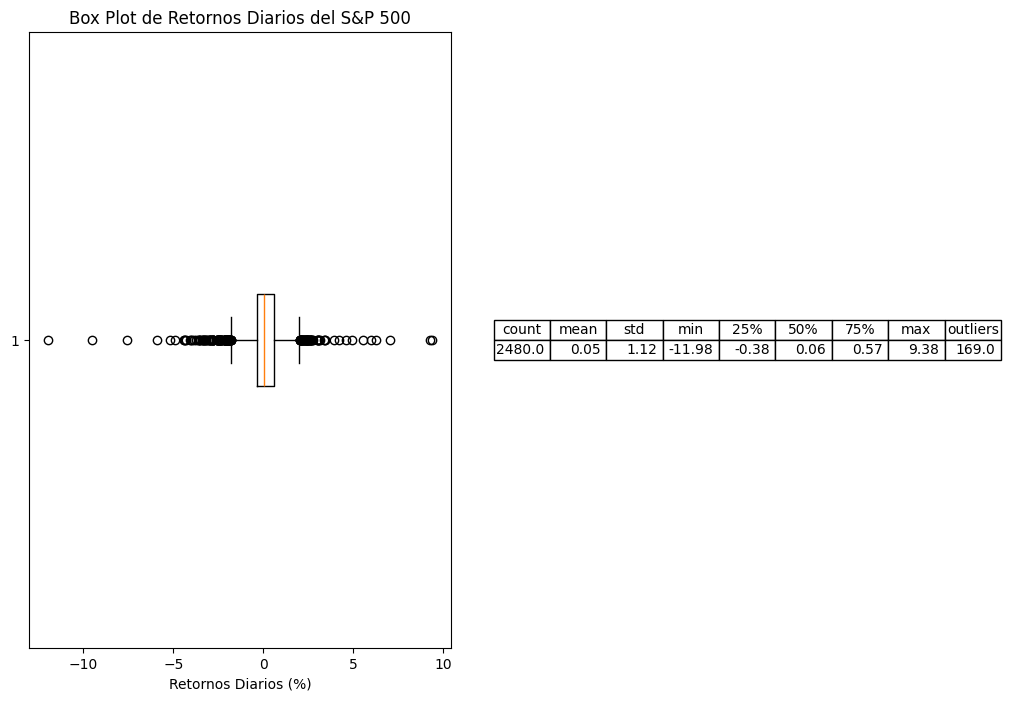

In [227]:
plt.figure(figsize=(12, 8))
plt.subplot(121)  # Posiciona el box plot en la izquierda
plt.boxplot(datos_sp500['Daily Returns'].dropna(), vert=False)
plt.title('Box Plot de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios (%)')

# Preparar los datos para la tabla, redondeando a dos decimales
tabla_descriptiva = tabla_descriptiva.round(2)

# Añadir una tabla con estadísticas al gráfico
plt.subplot(122)  # Posiciona la tabla en la derecha
plt.axis('tight')
plt.axis('off')
tabla_plot = plt.table(cellText=tabla_descriptiva.values,
                       colLabels=tabla_descriptiva.columns,
                       loc='center')
tabla_plot.auto_set_font_size(False)
tabla_plot.set_fontsize(10)
tabla_plot.scale(1.2, 1.2)  # Escala la tabla para que se ajuste mejor

# Mostrar el gráfico con la tabla
plt.show()



Centralidad: La línea naranja dentro de la caja indica la mediana (0.06%) de los retornos, que es ligeramente positiva.

Dispersión: Las cajas representan el rango intercuartil (IQR), desde el cuartil 25 (Q1, -0.38%) hasta el cuartil 75 (Q3, 0.57%). Esto muestra que la mayoría de los retornos diarios están contenidos dentro de este rango.

Simetría: El box plot parece ser bastante simétrico en torno a la mediana, indicando una distribución equilibrada de retornos alrededor del valor central.

Outliers: Los círculos fuera de los "bigotes" (las líneas que se extienden desde la caja hasta los valores mínimo y máximo no atípicos) representan valores atípicos o "outliers". Estos puntos muestran retornos extremadamente altos o bajos comparados con el resto de los datos. En el gráfico, se observan varios retornos diarios que son significativamente más altos o más bajos que la mayoría, lo que sugiere eventos de mercado extraordinarios o volatilidad durante ciertos períodos.

ANALISIS ESPECTRAL (TRANSFORMADA DE FOURIER)

ÚTIL PARA SACAR PATRONES (tendencias o movimientos cíclicos). S&P 500: La tendencia es a subir y literatura comenta que hay movimientos cíclicos según el día o los meses en el año. (no está contrastado con evidencia empírica)

Frecuencias bajas: son las que duran mucho tiempo

Frecuencias altas: son las que se repiten más pero son más cortas

La transformada de Fourier es un concepto matemático utilizado para transformar señales del dominio del tiempo (donde cada señal tiene un valor en cada instante de tiempo) al dominio de la frecuencia (donde cada señal se describe como una combinación de frecuencias). Esto se hace para facilitar el análisis y procesamiento de la información contenida en la señal.

Explicación Sencilla:
Imagina que tienes una canción. En el tiempo, se representa por cómo varía el sonido segundo a segundo. Pero si la descomponemos con la transformada de Fourier, lo que obtenemos es información sobre los distintos tonos musicales (frecuencias) que componen la canción. En lugar de saber qué ocurre en cada segundo, sabemos qué notas están presentes y cuán fuertes son.

¿Por qué se utiliza en el análisis de series de tiempo?
Descubrir Patrones Ocultos: En el análisis de series de tiempo, como datos financieros, meteorológicos, o señales de audio, es útil entender los ciclos o tendencias repetitivas. La transformada de Fourier ayuda a identificar estos patrones al revelar las frecuencias dominantes de los datos.
Filtrado de Datos: Permite separar componentes útiles de ruido. Por ejemplo, en telecomunicaciones, puede ayudar a eliminar el ruido de una señal para mejorar la claridad de la transmisión.
Compresión de Datos: En el ámbito de procesamiento de imágenes y señales de audio, la transformada de Fourier puede usarse para reducir el tamaño de los archivos, conservando las frecuencias más importantes y descartando las menos significativas.
Predicción y Análisis: Conocer las componentes frecuenciales de una serie de tiempo puede ayudar a construir modelos para predecir comportamientos futuros o para realizar análisis más profundos sobre la estabilidad o volatilidad de la serie observada.
En resumen, la transformada de Fourier convierte los datos del tiempo al dominio de frecuencia, proporcionando una nueva perspectiva que es a menudo más útil para el análisis y procesamiento de las series de tiempo.

In [228]:
# Calcula la transformada de Fourier para la columna 'Close'
fft_close = np.fft.fft(datos_sp500['Close'].dropna())

# Calcula la transformada de Fourier para la columna 'Daily Returns'
fft_returns = np.fft.fft(datos_sp500['Daily Returns'].dropna())


In [229]:
# Número de puntos en 'Close'
n_close = len(fft_close)

# Número de puntos en 'Daily Returns'
n_returns = len(fft_returns)

# Frecuencia de muestreo (suponemos que los datos son diarios)
# Obtener frecuencias para cada punto (asumimos datos diarios, por lo que la unidad es días)
frequencies_close = np.fft.fftfreq(n_close)

frequencies_returns = np.fft.fftfreq(n_returns)


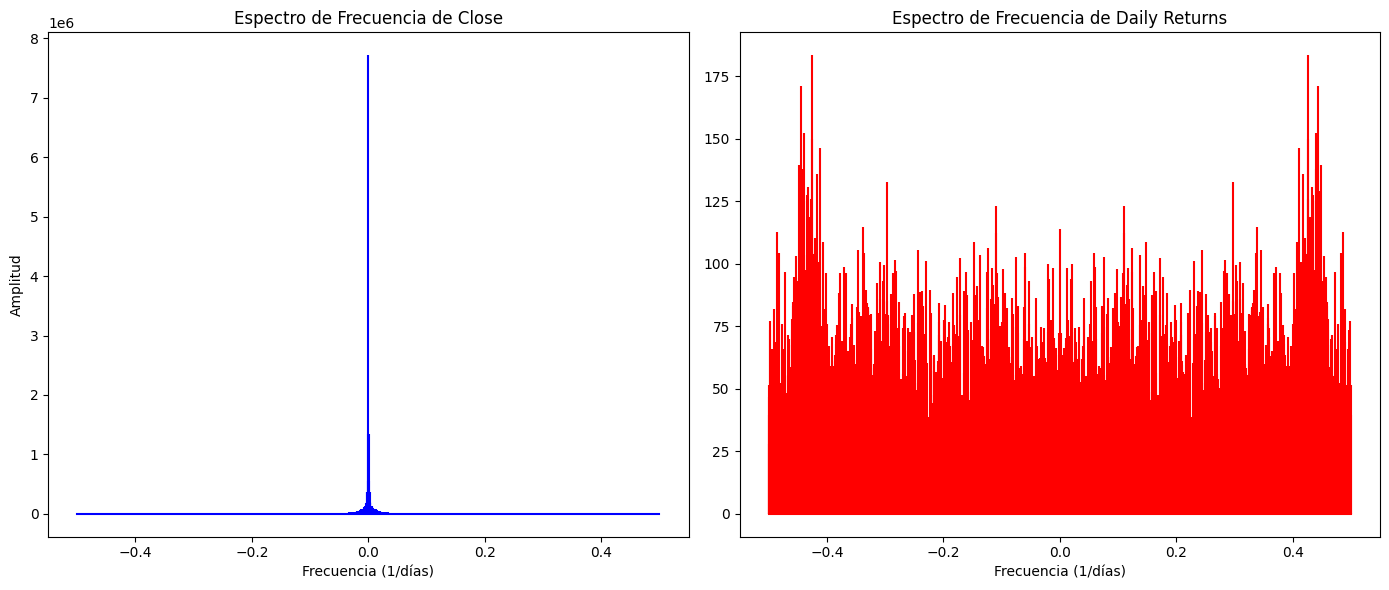

In [230]:
# Grafica la magnitud de la transformada de Fourier para 'Close'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Primer subgráfico
plt.stem(frequencies_close, np.abs(fft_close), 'b', markerfmt=" ", basefmt="-b")
plt.title('Espectro de Frecuencia de Close')
plt.xlabel('Frecuencia (1/días)')
plt.ylabel('Amplitud')

# Grafica la magnitud de la transformada de Fourier para 'Daily Returns'
plt.subplot(1, 2, 2)  # Segundo subgráfico
plt.stem(frequencies_returns, np.abs(fft_returns), 'r', markerfmt=" ", basefmt="-r")
plt.title('Espectro de Frecuencia de Daily Returns')
plt.xlabel('Frecuencia (1/días)')

# Mostrar gráfico
plt.tight_layout()
plt.show()


Estos gráficos muestran el espectro de frecuencia del índice S&P 500 y sus retornos diarios. A continuación se presenta una interpretación de cada uno:

Gráfico de la izquierda: Espectro de Frecuencia de Close (índice S&P 500)

Eje X (Frecuencia en 1/días): Muestra la frecuencia en términos de ciclos por día.

Eje Y (Amplitud): Indica la amplitud de las componentes de frecuencia.

Descripción:

Pico en frecuencia cero: Hay un pico muy alto en la frecuencia cero, lo cual es típico en series temporales que tienen una media diferente de cero. Este pico representa la componente constante (o media) del índice.

Frecuencias bajas: Las amplitudes para otras frecuencias son extremadamente bajas comparadas con el pico en la frecuencia cero, indicando que no hay componentes periódicas significativas en los datos de cierre del índice S&P 500.

Gráfico de la derecha: Espectro de Frecuencia de Daily Returns (retornos diarios)


Descripción:

Distribución uniforme: No hay un pico destacado en la frecuencia cero ni en ninguna otra frecuencia específica. La distribución de amplitud parece relativamente uniforme en todas las frecuencias.

Frecuencias variadas: Los retornos diarios del S&P 500 no muestran patrones periódicos claros, lo que es común para datos de retornos financieros, que suelen tener una naturaleza más ruidosa y menos predecible.

Resumen
Espectro de Frecuencia de Close: El índice S&P 500 tiene una componente constante fuerte (media diferente de cero) y no muestra componentes periódicas significativas en su espectro de frecuencia (tiene una tendencia fuerte a crecer históricamente).

Espectro de Frecuencia de Daily Returns: Los retornos diarios del índice S&P 500 no presentan patrones periódicos claros y muestran una distribución uniforme en su espectro de frecuencia, lo que refleja la naturaleza ruidosa e impredecible de los retornos financieros diarios.

Estas características son consistentes con la naturaleza de los mercados financieros, donde los precios tienden a seguir un paseo aleatorio y los retornos tienen una mayor variabilidad y menos estructura periódica.



Análisis de la Gráfica:
Pico en Frecuencias Bajas: El pico significativo muy cerca del origen (frecuencia casi 0) indica que hay una tendencia o un cambio muy lento en los datos, que domina la serie de tiempo. Esto podría representar tendencias a largo plazo en el mercado.
Decaimiento de la Potencia: A medida que aumenta la frecuencia, la potencia disminuye rápidamente, lo que indica que las fluctuaciones de alta frecuencia (cambios rápidos y frecuentes en los precios) tienen mucho menos impacto en la estructura general de los datos comparado con las tendencias a largo plazo.
Implicaciones:
Análisis de Inversiones: Los inversores a largo plazo podrían estar más interesados en las frecuencias más bajas, ya que estas reflejan las tendencias más sostenibles en el tiempo.
Modelado y Predicción: Modelos que intentan capturar o predecir tendencias a largo plazo pueden necesitar concentrarse en las frecuencias más bajas, mientras que para estrategias de trading de alta frecuencia, las frecuencias más altas podrían ser más relevantes, aunque aquí parecen tener poca potencia.
Esta interpretación ayuda a entender cómo se comporta el mercado en diferentes escalas de tiempo, facilitando decisiones basadas en el comportamiento y la volatilidad del mercado subyacente.

Es un random walk?

1. Prueba de Raíces Unitarias
Una de las pruebas más comunes para determinar si una serie temporal es un random walk es la prueba de Dickey-Fuller aumentada. Esta prueba verifica la presencia de una raíz unitaria, que es una característica de los procesos de random walk.

Estadístico de Prueba (ADF Statistic): Si es menor que los valores críticos, rechaza la hipótesis nula de raíz unitaria (no es un random walk).
p-value: Un p-value bajo (generalmente < 0.05) indica que puedes rechazar la hipótesis nula de que la serie es un random walk.

In [231]:
import statsmodels.api as sm

#Se elimina cualquier NaN para asegurar que la prueba funcione correctamente
daily_returns = datos_sp500['Daily Returns'].dropna()

# Realizar la prueba de Dickey-Fuller aumentada
result = sm.tsa.adfuller(daily_returns)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -16.07575285437555
p-value: 5.445572441413527e-29
Critical Values: {'1%': -3.432999172889712, '5%': -2.862710384473485, '10%': -2.5673930420019127}


Interpretación de los Resultados del Test de Dickey-Fuller Aumentado:
ADF Statistic: El valor de la estadística ADF es -16.031743925918775. Este valor es el resultado del test y se compara con los valores críticos para determinar la estacionariedad de la serie.

p-value: El valor p es extremadamente pequeño (6.046631388776374e-29), lo cual es prácticamente cero. Un valor p bajo (típicamente < 0.05) indica fuertes evidencias contra la hipótesis nula de que la serie tiene una raíz unitaria (es decir, la serie de los daily returns ES ESTACIONARIA).

Critical Values: Los valores críticos para el test a diferentes niveles de significancia son:

1%: -3.4329938176251593
5%: -2.8627080196071697
10%: -2.567391782912405
Conclusiones del Test:
Estacionariedad: Dado que el valor estadístico ADF (-16.0317) es más negativo que cualquiera de los valores críticos, rechazamos la hipótesis nula con un alto nivel de confianza. Esto significa que hay suficiente evidencia estadística para afirmar que la serie temporal es estacionaria.

Significado de la Estacionariedad:

La estacionariedad implica que las propiedades estadísticas de la serie como la media, varianza y covarianza son constantes en el tiempo, lo cual es crucial para muchos métodos analíticos en finanzas y pronósticos.
Para los modelos de pronóstico y análisis financiero, trabajar con datos estacionarios es favorable porque simplifica el modelo y las inferencias que se pueden hacer sobre los datos.

Aplicaciones en Finanzas:
Al ser estacionarios, los retornos diarios del S&P 500 pueden ser modelados y pronosticados con mayor precisión utilizando modelos ARIMA, modelos de volatilidad como GARCH, o incluso métodos más complejos.
La estacionariedad también implica que no hay tendencias persistentes que puedan predecirse en el largo plazo, ya que cualquier efecto tiende a ser temporal.
Recomendaciones Adicionales:
Modelado de Volatilidad: Aunque los retornos puedan ser estacionarios, la volatilidad de los retornos puede no serlo. Se recomienda considerar la posibilidad de examinar y modelar la volatilidad, tal vez con modelos como GARCH, si el enfoque es el riesgo y la gestión de carteras.
Investigación de Dependencias Temporales: Incluso si la serie es estacionaria, podría haber autocorrelaciones en los datos que podrían explotarse en el modelado predictivo.
Este test es una herramienta valiosa en la caja de herramientas de un analista financiero, proporcionando información crítica sobre la naturaleza de los retornos y ayudando a guiar las decisiones de modelado y pronóstico.


2. Análisis de Autocorrelación
Un random walk debería mostrar una autocorrelación significativa solo en el primer desfase (lag) y ninguna autocorrelación significativa en los desfases mayores.
Interpretación: En un random walk, se esperaría ver una fuerte autocorrelación en el primer lag y una rápida disminución a medida que aumentan los lags. Si se observan autocorrelaciones significativas en lags mayores, eso sugiere que no es un random walk.

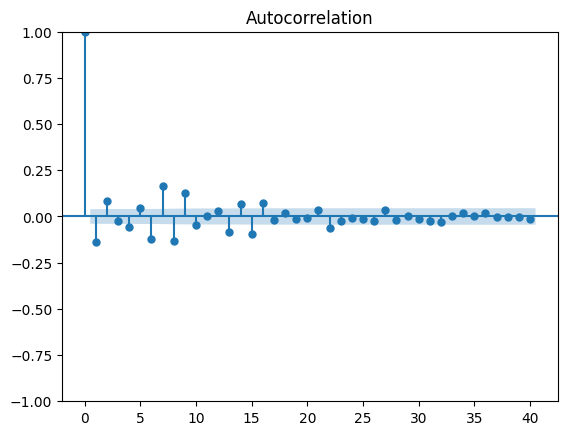

In [232]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Graficar la función de autocorrelación
plot_acf(daily_returns, lags=40)
plt.show()


Este gráfico muestra cómo los valores de una serie temporal se relacionan con sus propios retrasos anteriores.

Interpretación de la Función de Autocorrelación:
Lag 0: Como se espera, la autocorrelación en el retardo cero es siempre 1, porque una serie está perfectamente correlacionada consigo misma.
Decaimiento Rápido: La autocorrelación cae dramáticamente después del primer retardo y se acerca a cero muy rápidamente, lo que sugiere que no hay una fuerte dependencia lineal entre los valores sucesivos más allá del retardo inmediato.
Valores cercanos a cero para retrasos mayores: Los valores de autocorrelación que flotan alrededor de cero para retrasos más altos sugieren que no hay autocorrelaciones significativas en retrasos más allá del primero. Esto es típico en procesos que son principalmente aleatorios o 'ruido blanco'.

Conclusión del Análisis de la ACF:
Independencia de Retornos Diarios:

Si esta ACF es para los retornos diarios de un activo financiero, como el S&P 500, implica que los retornos diarios son en gran parte independientes día a día, con excepción de una leve correlación del primer día que puede no ser estadísticamente significativa dependiendo de la confianza del intervalo no mostrado aquí.
La falta de autocorrelaciones significativas en retrasos mayores sugiere que usar modelos autoregresivos simples (como un AR(1)) probablemente no mejorará significativamente las predicciones de los retornos, dado que no hay mucha información en los retrasos pasados que se pueda explotar para pronósticos futuros.

Modelado de la Serie Temporal:

Dado que los retornos parecen comportarse como ruido blanco, los modelos que intentan predecir retornos futuros basados en retornos pasados directamente podrían no ser eficaces. Sin embargo, podría ser útil explorar modelos que consideren la volatilidad de los retornos, como los modelos GARCH, que son capaces de modelar la varianza heterocedástica observada comúnmente en los retornos financieros.

Implicaciones para la Estrategia de Trading:

La falta de autocorrelación sugiere que intentar estrategias de trading basadas en patrones de precios pasados (al menos en términos de retornos simples diarios) puede no ser fructífero. Las estrategias que se centran en otras métricas, como el volumen o la volatilidad, o que utilizan información externa, podrían ser más prometedoras.

3. Volatilidad de los Retornos

Si los retornos son un random walk, su distribución debería ser consistente a lo largo del tiempo. Cualquier cambio significativo en la volatilidad podría sugerir que no es un random walk.
Interpretación: Variaciones significativas en la volatilidad podrían indicar que los retornos no siguen un random walk.

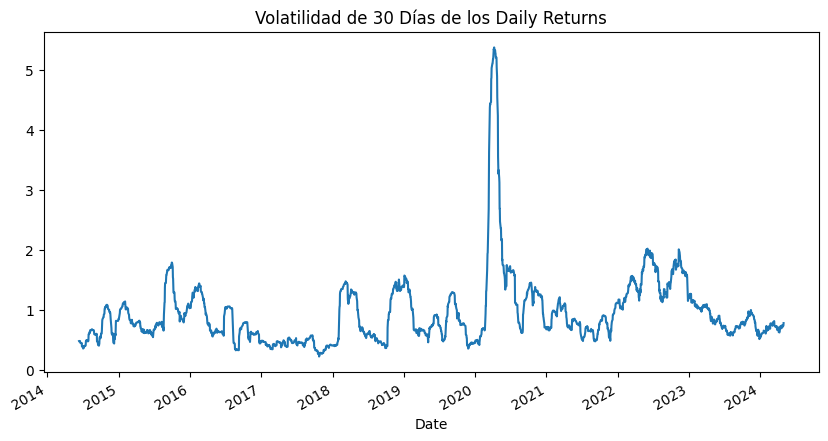

In [233]:
# Calcular la volatilidad móvil de los retornos diarios (ejemplo: ventana de 30 días)
daily_returns['Volatility'] = daily_returns.rolling(window=30).std()

# Graficar la volatilidad
daily_returns['Volatility'].plot(figsize=(10, 5))
plt.title('Volatilidad de 30 Días de los Daily Returns')
plt.show()


Niveles de Volatilidad: La volatilidad varía significativamente a lo largo del tiempo. Periodos de baja volatilidad alternan con picos donde la volatilidad aumenta drásticamente.


Interpretación Conjunta:
No Random Walk: Todos estos indicadores juntos sugieren fuertemente que los retornos diarios del S&P 500 no siguen un random walk. En su lugar, parecen ser estacionarios con cambios significativos en la volatilidad, lo que podría ser capturado por modelos más sofisticados que solo un simple modelo de caminata aleatoria.

Importancia de Modelos de Volatilidad: Dada la variabilidad evidente en la volatilidad a lo largo del tiempo, modelos que pueden adaptarse a volatilidades cambiantes (como los modelos GARCH) pueden ser más adecuados para describir y predecir los retornos del S&P 500.

En conclusión, los retornos diarios del S&P 500 muestran características de estacionariedad, no consistencia con un random walk, y una variabilidad significativa en la volatilidad, lo que sugiere que el comportamiento del mercado puede ser influenciado por factores estructurales y eventos de mercado.








CORRELACIONES

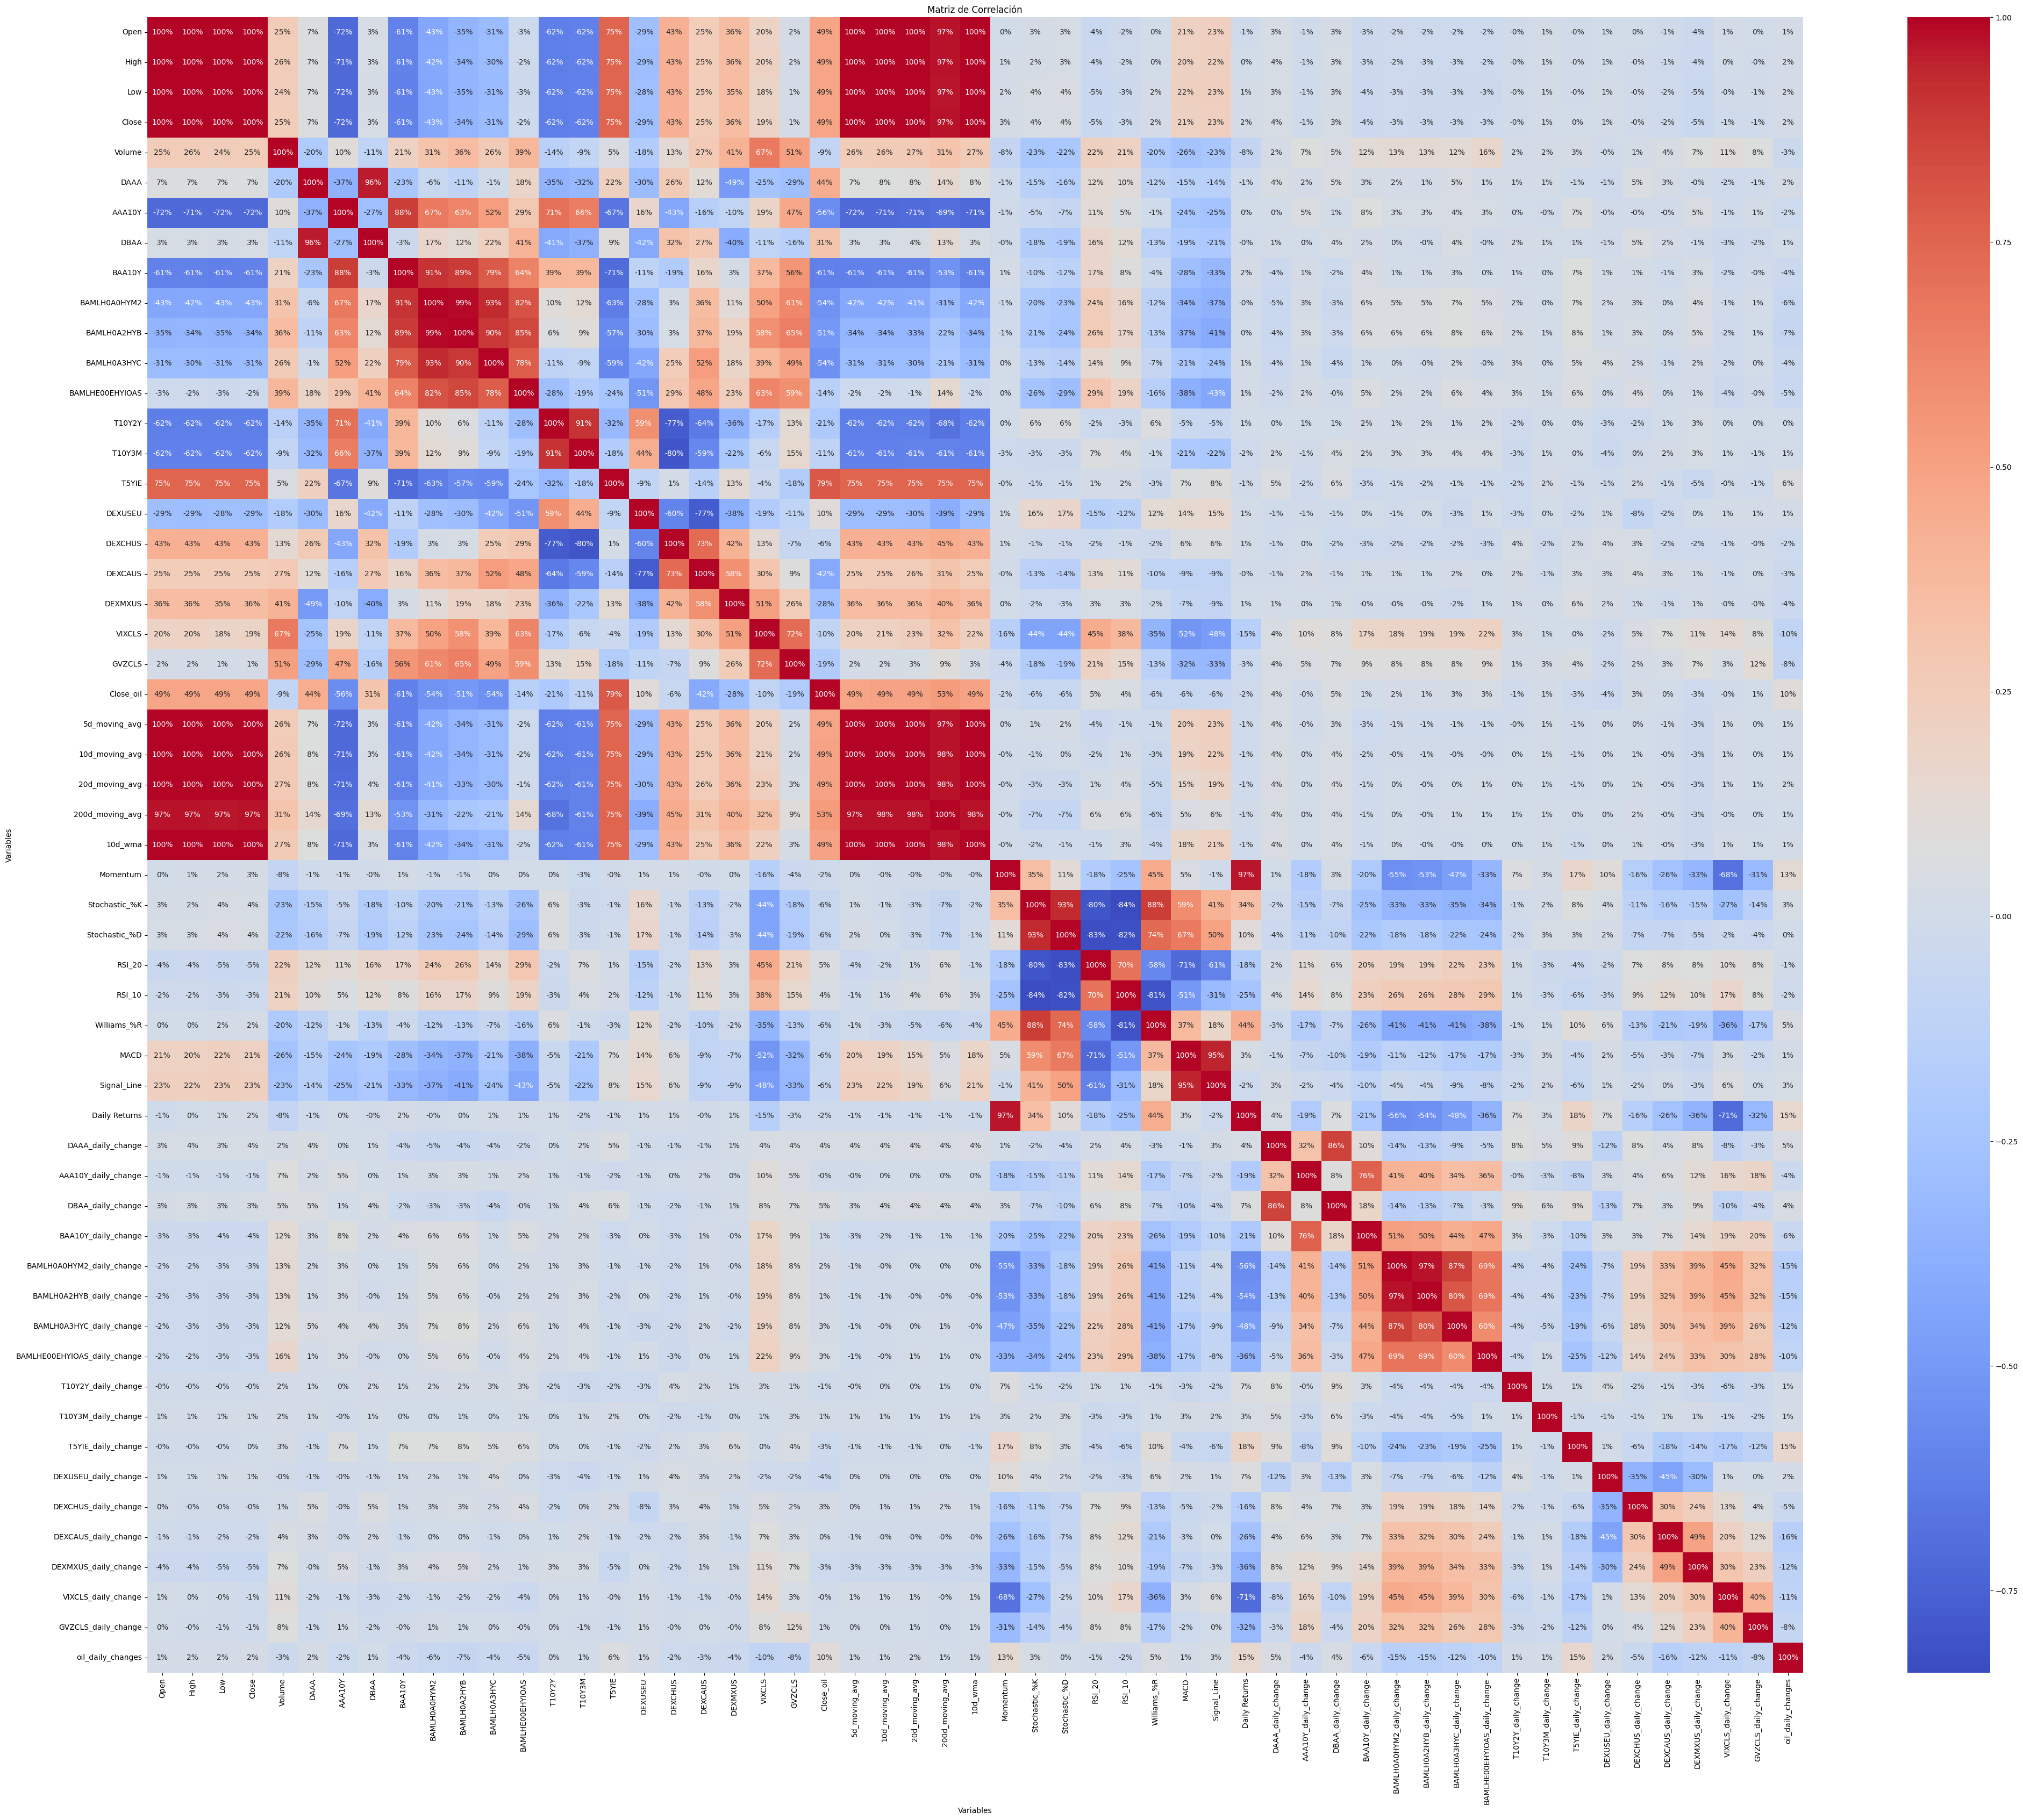

In [234]:
import seaborn as sns


# Calcular la matriz de correlación
corr_matrix = AllVar_df.corr()

# Crear el heatmap usando seaborn
plt.figure(figsize=(50, 40))  
sns.heatmap(corr_matrix, annot=True, fmt=".0%", cmap='coolwarm', cbar=True, square=True)

plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Mostrar el gráfico
plt.show()


In [235]:
print(corr_matrix)

                                  Open      High       Low     Close  \
Open                          1.000000  0.999828  0.999741  0.999549   
High                          0.999828  1.000000  0.999649  0.999753   
Low                           0.999741  0.999649  1.000000  0.999784   
Close                         0.999549  0.999753  0.999784  1.000000   
Volume                        0.252356  0.257974  0.242780  0.249795   
DAAA                          0.071039  0.070852  0.071681  0.070995   
AAA10Y                       -0.716490 -0.714492 -0.718845 -0.716281   
DBAA                          0.029219  0.030235  0.028854  0.029397   
BAA10Y                       -0.611114 -0.607503 -0.614600 -0.610571   
BAMLH0A0HYM2                 -0.425242 -0.420659 -0.430327 -0.425118   
BAMLH0A2HYB                  -0.345101 -0.339971 -0.350702 -0.344873   
BAMLH0A3HYC                  -0.307424 -0.303922 -0.311067 -0.307116   
BAMLHE00EHYIOAS              -0.025180 -0.019040 -0.031145 -0.02

Análisis General de la Matriz de Correlación

Correlaciones entre Precios de Apertura, Cierre, Máximo y Mínimo:

Variables de precio ('Open', 'High', 'Low', 'Close'): Exhiben correlaciones muy altas entre sí, cercanas a 1. Esto sugiere que cualquiera de estas variables puede representar efectivamente a las demás en la captura de información del precio del activo, lo cual es relevante para modelos predictivos que requieren reducir la multicolinealidad.

Correlaciones con Medias Móviles:
Variables ('5d_moving_avg', '10d_moving_avg', '20d_moving_avg'): También presentan alta correlación con las variables de precios. Podría ser prudente utilizar una de estas medias móviles en lugar de múltiples para representar tendencias de precios en modelos predictivos, evitando así redundancias.

Variables de Volumen y Volatilidad:
'Volume' y 'VIXCLS': Ambos muestran correlaciones moderadas con los precios. El volumen tiene una relación positiva, mientras que el VIX muestra una relación negativa, lo que sugiere que ambos ofrecen información diversa que no está directamente relacionada con los movimientos de precios y podría ser útil para capturar la dinámica del mercado en modelos predictivos.

Indicadores Técnicos:
'RSI', 'MACD', 'Stochastic_%K/D', 'Williams_%R': Estos indicadores muestran correlaciones bajas a moderadas con los precios. Podrían ser útiles para capturar características del comportamiento del precio no evidentes solo a través del análisis de precios.

Variables Económicas:
'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS': Las tasas de cambio muestran correlaciones negativas con ciertas variables macroeconómicas como 'AAA10Y' y 'BAA10Y'. Esto puede indicar interacciones económicas complejas que podrían explorarse en modelos avanzados como los basados en LSTM.

Recomendaciones para la Selección de Variables
Evitar Redundancia:

Dada la alta correlación entre las series de precios y medias móviles, se recomienda usar una sola representación de cada grupo (por ejemplo, optar por 'Close' o '20d_moving_avg', pero no ambas).

Incluir Diversidad:

Incluir variables menos correlacionadas entre sí proporciona una visión más completa del comportamiento del mercado. Combinar 'Close' con 'Volume' y 'VIXCLS' podría ser útil.

Exploración de Indicadores Técnicos:

Los indicadores técnicos que ofrecen perspectivas distintas a las directamente relacionadas con los precios pueden ser valiosos, especialmente en modelos que pueden manejar múltiples entradas sin sufrir de multicolinealidad.

Modelos Específicos:

En modelos como Random Forest y LSTM, que manejan bien la alta dimensionalidad y complejidad, considerar incluir un conjunto más amplio de variables. Luego, emplear técnicas de importancia de características para optimizar el modelo.

Para la regresión logística, se recomienda evitar la multicolinealidad para mejorar la estabilidad y la interpretabilidad del modelo.
